In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt

Here we determine the paths of images we're going to use.

In [2]:
paths = [
    './im03.jpg',
    './im03-masks.jpg',
    './im04.jpg',
    './im04-mask.jpg'
]

This function converts BGR channeling to RGB so that we can plot images with matplotlib.

In [3]:
def convert_BGR_to_RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

First we add all our images to our images list.

In [4]:
images = []
for path in paths:
    images.append(cv2.imread(path))

As you can I masked each subject with a different color so I can select the area easier and inpaint it.

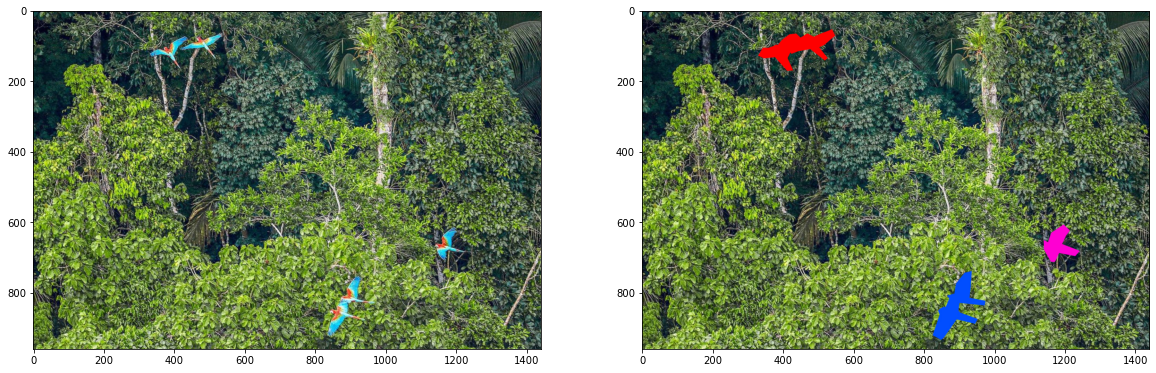

In [5]:
fig, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(convert_BGR_to_RGB(images[0]))
ax[1].imshow(convert_BGR_to_RGB(images[1]))

The same logic happens here but there is only one subject insead of 3

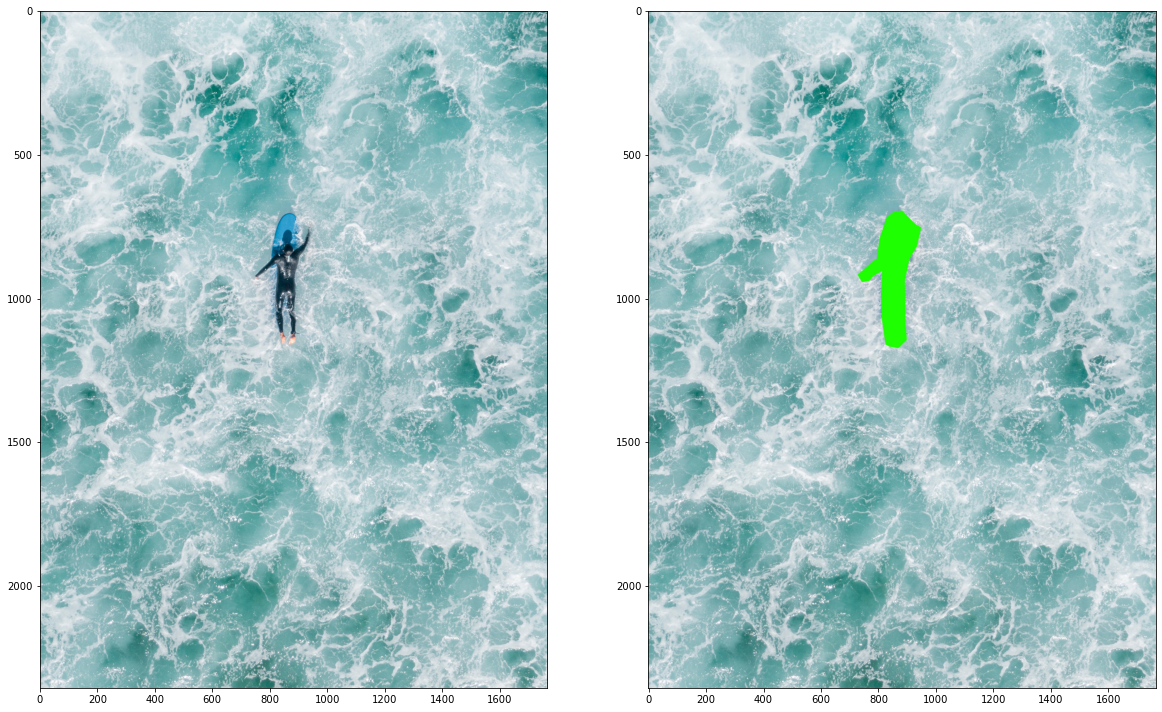

In [6]:
fig, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(convert_BGR_to_RGB(images[2]))
ax[1].imshow(convert_BGR_to_RGB(images[3]))

We define Image class for every image we want to inapaint. this class gets the original_image, mask_image and mask colors as input and automatically generates a binary mask for each object so we can focus on removing each object.

The Mask class holds the information about the masks. for example where it is located or what is the width or height of that particular mask.

In [7]:
class Image:
    def __init__(self, image, mask_image, mask_colors):
        self.image = image
        self.mask_image = mask_image
        self.mask_colors = mask_colors
        self.masks = []
        self.create_masks()

    def create_masks(self):
        for mask_color in self.mask_colors:
            self.masks.append(Mask(mask_color, self.mask_image))
    
    def return_masks(self):
        masks = []
        for mask in self.masks:
            masks.append(mask.mask)
        return masks


class Mask:
    def __init__(self, mask_color, img):
        self.mask_color = mask_color
        self.mask = self.find_mask(img)
        mask_locations = list(zip(*np.where(self.mask == 255)))
        x_min, y_min = np.min(mask_locations, axis=0)
        x_max, y_max = np.max(mask_locations, axis=0)
        self.start_position = (x_min - 10, y_min - 10)
        self.width = x_max - x_min + 10
        self.height = y_max - y_min + 10

    def find_mask(self, img):
        mask = np.zeros(shape=img.shape[:2])
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                flag = True
                for channel in range(3):
                    if np.abs(img[row, col, channel] - self.mask_color[channel]) <= 2:
                        continue
                    else:
                        flag = False
                        break
                mask[row, col] = 255 if flag else 0
        return mask

We load the first image and make an instance of Image class using mask image and array of mask colors.

In [8]:
img_1_mask_colors = [[210,0,255], [255, 78, 0], [0, 0, 255]]
img_1 = Image(images[0], images[1], img_1_mask_colors)

We instanciate an object for second image as well.

In [9]:
img_2_mask_colors = [[0, 255, 30]]
img_2 = Image(images[2], images[3], img_2_mask_colors)

if we iterate over img_1.masks we can see that each object is detected and saved as a seperate mask.

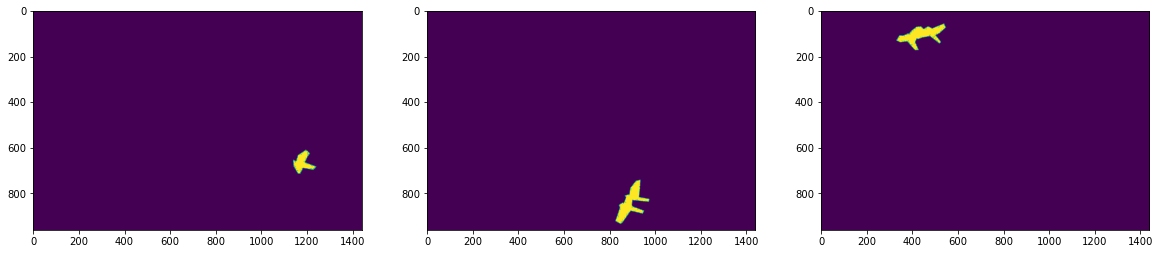

In [10]:
fig, ax = plt.subplots(1,3, figsize=(20, 20))
for i, mask in zip(range(len(img_1.return_masks())), img_1.return_masks()):
    ax[i].imshow(mask)

For the second image, we repeat the process.

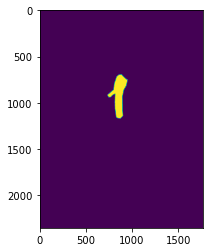

In [11]:
for mask in img_2.return_masks():
    plt.imshow(mask)

Following sections are exactly similar to functions in question 2. Therefore I avoid explaning what each function does. for further information, visit report file of question 2.

In [12]:
def minimum_cost_path(section_1, section_2):
    rows, cols = section_1.shape[:2]
    DP = np.zeros((rows, cols), dtype=np.float32)
    difference_matrix = np.sum(np.abs(section_1 - section_2)**2, axis=2)
    DP[0, :] = difference_matrix[0, :]
    backtrace = np.zeros((rows, cols)) # 1:UP-LEFT  2:UP-CENTER 3:UP-RIGHT

    for row in range(rows):
        for col in range(cols):
            # Dynamic Programming
            possible_values = []

            if col == 0:
                possible_values = [1e5, DP[row-1, col], DP[row-1, col + 1]]
            elif col == cols - 1:
                possible_values = [DP[row-1, col - 1], DP[row-1, col], 1e5]
            else:
                possible_values = [DP[row-1, col - 1], DP[row-1, col], DP[row-1, col + 1]]

            DP[row, col] = min(possible_values)
            backtrace[row, col] = possible_values.index(DP[row, col]) + 1
            DP[row, col] += difference_matrix[row, col]

    return DP, backtrace

In [13]:
def backtrace_path(DP, backtrace, vetical=True):
    rows, cols = DP.shape
    row_index = rows - 1
    col_index = np.argmin(DP[row_index])
    path = []
    while row_index >= 0 :
        path.append((row_index, col_index) if vetical else (col_index, row_index))
        if backtrace[row_index, col_index] == 1:
            col_index -= 1
        elif backtrace[row_index, col_index] == 3:
            col_index += 1
        row_index -= 1
    
    return path[::-1]

In [14]:
def find_minimum_cost_path(section_1, section_2, vertical=True):
    DP, backtrace = minimum_cost_path(section_1, section_2) if vertical else\
                    minimum_cost_path(cv2.transpose(section_1),
                                      cv2.transpose(section_2))
    
    return backtrace_path(DP, backtrace, vertical)

In [15]:
def create_blend_masks_horizontal(path, overlap_shape):
    rows, cols = overlap_shape
    mask_left = np.zeros((rows, cols))
    mask_right = np.ones((rows, cols))
    for row, col in path:
        mask_left[row, :col] = np.linspace(1, 0.7, num=col, endpoint=False)
        mask_left[row, col] = 0.5
        mask_left[row, col+1:] = np.linspace(0.3, 0, num=cols - col - 1, endpoint=True) 

    return mask_left, mask_right - mask_left

In [16]:
def create_blend_masks_vertical(path, overlap_shape):
    rows, cols = overlap_shape
    mask_up = np.zeros((rows, cols))
    mask_down = np.ones((rows, cols))
    for row, col in path:
        mask_up[:row, col] = np.linspace(1, 0.7, num=row, endpoint=False)
        mask_up[row, col] = 0.5
        mask_up[row+1:, col] = np.linspace(0.3, 0, num=rows - row-1, endpoint=True)  

    return mask_up, mask_down - mask_up

In [17]:
def handle_masks(current_row, current_col, fill_img, patch, box_size, overlap):
    
    path_v = []
    path_h = []
    mask_patch = np.ones((box_size, box_size))
    mask_fill_img = np.zeros((box_size, box_size))

    if current_row >= overlap:
        path_h = find_minimum_cost_path(fill_img[current_row: current_row + overlap, current_col: current_col + box_size],
                                        patch[:overlap, :],
                                        vertical=False)
    if current_col >= overlap:
        path_v = find_minimum_cost_path(fill_img[current_row: current_row + box_size, current_col: current_col + overlap],
                                        patch[:, :overlap],
                                        vertical=True)
    
    mask_left_right = create_blend_masks_horizontal(path_v, (box_size, overlap)) if current_col >= overlap else None
    mask_up_down = create_blend_masks_vertical(path_h, (overlap, box_size)) if current_row >= overlap else None

    if current_col >= overlap:
        mask_fill_img[:box_size, :overlap] = mask_left_right[0]
        mask_patch[:box_size, :overlap] = mask_left_right[1]

    if current_row >= overlap:
        mask_fill_img[:overlap, :box_size] = mask_up_down[0]
        mask_patch[:overlap, :box_size] = mask_up_down[1]
    
    return mask_patch, mask_fill_img

In [18]:
def find_new_patch(current_row, current_col, start_position, width, height, org_img, fill_img, mask_img, box_size, overlap):
    
    mask = np.zeros((box_size, box_size, 3), dtype=np.uint8)
    template = np.zeros((box_size, box_size, 3), dtype=np.uint8)
        
    random_samples = 10
    
    if np.count_nonzero(mask_img[current_row: current_row + box_size, current_col: current_col + box_size])==0:
        return org_img[current_row: current_row + box_size, current_col: current_col + box_size]

    if current_row > overlap :
        template[: overlap, :box_size, :] = \
            fill_img[current_row: current_row + overlap, current_col: current_col + box_size, :]
        mask[: overlap, :box_size, :] = 255

    if current_col > overlap:
        template[:box_size, : + overlap, :] = \
            fill_img[current_row: current_row + box_size, current_col: current_col + overlap, :]
        mask[:box_size, : overlap, :] = 255

    res = cv2.matchTemplate(fill_img,
                            template,
                            cv2.TM_SQDIFF,
                            mask=mask)


    ind = np.unravel_index(np.argsort(res, axis=None), res.shape)
    random_choice = np.random.randint(random_samples)
    inc = 1
    random_row, random_col = ind[0][random_choice], ind[1][random_choice]
    random_row, random_col = int(random_row + box_size / 2), int(random_col + box_size / 2)
    
    while  (start_position[0] - box_size < random_row < start_position[0] + width and \
            start_position[1] - box_size < random_col < start_position[1] + height) or \
            random_row + box_size > fill_img.shape[0] or random_col + box_size > fill_img.shape[1]:
        inc += 1
        random_choice = np.random.randint(random_samples) + int(inc)
        random_row, random_col = ind[0][random_choice], ind[1][random_choice]
        random_row, random_col = int(random_row + box_size / 2), int(random_col + box_size / 2)
    
    patch = fill_img[random_row: random_row + box_size, random_col: random_col + box_size]
    
    mask_patch, mask_fill_img = handle_masks(current_row, current_col, fill_img, patch, box_size, overlap)
    mask_p = np.zeros_like(patch, dtype=np.float32)
    mask_t = np.zeros_like(patch, dtype=np.float32)

    for i in range(3):
        mask_p[:, :, i] = mask_patch[:, :]
        mask_t[:, :, i] = mask_fill_img[:, :]

    image_patch = np.multiply(mask_p, patch, dtype=np.float32)
    image_texture = np.multiply(mask_t,
                                fill_img[current_row: current_row + box_size, current_col: current_col + box_size],
                                dtype=np.float32)

    return (image_patch + image_texture).astype(np.uint8)

In [19]:
def normalize_weights(w1, w2):
    add = np.add(w1,w2)
    extra = add - np.ones(shape=w1.shape)
    return w1 - extra * (w1 / add), w2 - extra * (w2 / add)

This function iterates over the mask area and tries to fill it. at the end it tries to find the boundry cut for each direction and blend them together so that the final result feels almos seemless.

In [20]:
def inpaint_image(img, start_position, width, height, mask, box_size, overlap):
    fill_img = img.copy()
    row, col = start_position
    fill_img[row: row + width, col:col+height] = 0
    row, col = row - overlap, col - overlap
    while row < start_position[0] + width + overlap:
        while col < start_position[1] + height + overlap:
            fill_img[row:row + box_size, col:col + box_size, :] =\
                find_new_patch(row, col,start_position, width, height, img, fill_img, mask, box_size, overlap)
            col += (box_size - overlap)
        col = start_position[1]
        row += (box_size - overlap)
        
    mask_patch = np.ones((width + 2 * overlap, height + 2 * overlap))
    mask_fill_img = np.zeros((width + 2 * overlap, height + 2 * overlap))

    begin_x, begin_y = start_position
    end_x, end_y = start_position[0] + width, start_position[1] + height
    
    path_h_d = find_minimum_cost_path(fill_img[end_x: end_x + overlap, begin_y - overlap: end_y + overlap],
                                    img[end_x: end_x + overlap, begin_y - overlap: end_y + overlap],
                                    vertical=False)
    
    path_v_r = find_minimum_cost_path(fill_img[begin_x-overlap: end_x + overlap, end_y: end_y + overlap],
                                    img[begin_x-overlap: end_x + overlap, end_y: end_y + overlap],
                                    vertical=True)
    
    path_h_u = find_minimum_cost_path(fill_img[begin_x - overlap: begin_x, begin_y-overlap: end_y + overlap],
                                    img[begin_x - overlap: begin_x, begin_y-overlap: end_y + overlap],
                                    vertical=False)
    
    path_v_l = find_minimum_cost_path(fill_img[begin_x - overlap: end_x + overlap, begin_y - overlap: begin_y],
                                    img[begin_x - overlap: end_x + overlap, begin_y - overlap: begin_y],
                                    vertical=True)
    
    
    mask_left_right = create_blend_masks_horizontal(path_v_r, (width + 2 * overlap, overlap)) 
    mask_up_down = create_blend_masks_vertical(path_h_d, (overlap, height + 2 * overlap))
    mask_right_left = create_blend_masks_horizontal(path_v_l, (width + 2 * overlap, overlap))
    mask_down_up = create_blend_masks_vertical(path_h_u, (overlap, height + 2 * overlap)) 
    

    mask_fill_img[:, -overlap:] = np.fliplr(mask_left_right[0])
    mask_patch[:, -overlap:] = np.fliplr(mask_left_right[1])
    
    mask_fill_img[:, :overlap] += mask_right_left[0]
    mask_patch[:, :overlap] += mask_right_left[1]

    mask_fill_img[-overlap:,:] += np.flipud(mask_up_down[0])
    mask_patch[-overlap:,:] += np.flipud(mask_up_down[1])
    
    mask_fill_img[:overlap,:] += mask_down_up[0]
    mask_patch[:overlap,:] += mask_down_up[1]
    
    mask_fill_img, mask_patch = normalize_weights(mask_fill_img, mask_patch)
    
    mask_p = np.zeros((width + 2 * overlap, height + 2 * overlap, 3), dtype=np.float32)
    mask_t = np.zeros((width + 2 * overlap, height + 2 * overlap, 3), dtype=np.float32)
    
    fill_img = fill_img.astype(np.uint8)
    for i in range(3): 
        mask_p[:,:,i] = mask_patch[:, :]
        mask_t[:,:,i] = mask_fill_img[:, :]
        
    fill_img[begin_x - overlap: end_x + overlap, begin_y - overlap: end_y + overlap] =\
            fill_img[begin_x - overlap: end_x + overlap, begin_y - overlap: end_y + overlap] * mask_p +\
            img[begin_x - overlap: end_x + overlap, begin_y - overlap: end_y + overlap] * mask_t
            
    return (fill_img).astype(np.uint8)

We can see the process of inpainting the selected objects. We'iterate over the mask out image instance has and then we perofrm inpainting on them one by one.

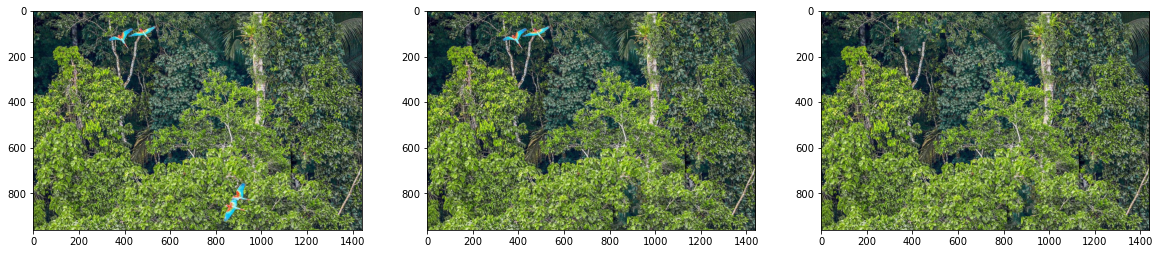

In [21]:
fig, ax = plt.subplots(1,3, figsize=(20, 20))
index = 0
img_1.image = images[0]
for mask in img_1.masks:
    box_size = 30
    overlap = 10
    modified_img = inpaint_image(img_1.image, mask.start_position, mask.width, mask.height, mask.mask, box_size, overlap)
    ax[index].imshow(convert_BGR_to_RGB(modified_img))
    img_1.image = modified_img
    index += 1

As we can observe the final result for second image is also satisfying.

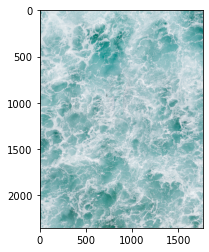

In [22]:
img_2.image = images[2]
for mask in img_2.masks:
    box_size = 20
    overlap = int(box_size/2)
    modified_img = inpaint_image(images[2], mask.start_position, mask.width, mask.height, mask.mask, box_size, overlap)
    plt.imshow(convert_BGR_to_RGB(modified_img))
    img_2.image = modified_img